This Kernel implements a modified version of **a state-of-art end-to-end neural correference resolution model** published in 2017: https://www.aclweb.org/anthology/D17-1018.
This completition only focus on a specific case of  the generic reference resolution problem, and we only need pick out the correct mention from two candidates, which simplifies the model implementation.

You can compare the result of this model  with the result by other non-RNN based DL models implemented in another kernel: https://www.kaggle.com/keyit92/coreference-resolution-by-mlp-cnn-coattention-nn. 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("../input"))

from spacy.lang.en import English
from spacy.pipeline import DependencyParser
import spacy
from nltk import Tree
from category_encoders.one_hot import OneHotEncoder
from gensim.models import Word2Vec
import time

import numpy as np
from keras import backend
from keras import layers
from keras import models
from keras import initializers, regularizers, constraints, activations
from keras.engine import Layer
import keras.backend as K
from keras.layers import merge
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import sklearn.metrics as skm
from keras.preprocessing import sequence
from keras.preprocessing import text as ktext

import tensorflow as tf

# Any results you write to the current directory are saved as output.
#plt.ioff()

['gendered-pronoun-resolution', 'gap-data', 'gap-coreference']


Using TensorFlow backend.


In [2]:
def measure_log_loss(ground, preds):
    preds = preds.tolist()
    return skm.log_loss(ground, preds, labels=[0, 1, 2], eps=10**-15)

In [3]:
def add_results(df, probs):
    df.loc[:, 'A'] = pd.Series(probs[:, 0])
    df.loc[:, 'B'] = pd.Series(probs[:, 1])
    df.loc[:, 'NEITHER'] = pd.Series(probs[:, 2])
    
def drop_results(df):
    df.drop(columns=['A', 'B', 'NEITHER'], inplace=True)

# Import Data

In [4]:
DATA_ROOT = '../input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-data')

df_path1 = os.path.join(GAP_DATA_FOLDER, 'gap-phase1.csv')
df_path2 = os.path.join(GAP_DATA_FOLDER, 'gap-phase2.csv')

df = pd.read_csv(df_path1)
test_df = pd.read_csv(df_path2)

# split development data
dev_size = 454
dev_df = df.iloc[:dev_size]
train_df = df.iloc[dev_size:].reset_index()

In [5]:
print(train_df.shape)
train_df.head()

(4000, 12)


,index,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,454,validation-222,She informs Will and Roz Washington (NeNe Leak...,his,367,John,241,False,Bob,334,True,"http://en.wikipedia.org/wiki/Love,_Love,_Love_..."
1,455,development-1069,It is generally accepted that he was the first...,he,359,John,300,True,Bob,323,False,http://en.wikipedia.org/wiki/Carl_Wilhelm_Scheele
2,456,validation-360,The two women are shocked to see each other an...,her,277,John,243,True,Bob,256,False,http://en.wikipedia.org/wiki/Aventurera
3,457,development-1831,"The film was Fox's first real talkie, using th...",her,259,John,241,True,Bob,252,False,http://en.wikipedia.org/wiki/Mother_Knows_Best...
4,458,development-1735,In what she describes as ``a moment of artisti...,her,277,John,291,True,Bob,319,False,http://en.wikipedia.org/wiki/Maisie_Dobbs_(novel)


# Explore Features for Building Mention-Pair Distributed Representation

In [6]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'textcat'])

In [7]:
def bs(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid + 1
    return lo

def bs_(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid
    return lo

def ohe_dist(dist, buckets):
    idx = bs_(buckets, dist)
    oh = np.zeros(shape=(len(buckets),), dtype=np.float32)
    oh[idx] = 1
    
    return oh

 ##  Position Features

Encode the absolute positions in the sentence and the relative position between the pronoun and the entities.

In [8]:
num_pos_features = 45

In [9]:
def extrac_positional_features(text, char_offset1, char_offset2):
    doc = nlp(text)
    max_len = 64
    
    # char offset to token offset
    lens = [token.idx for token in doc]
    mention_offset1 = bs(lens, char_offset1) - 1
    mention_offset2 = bs(lens, char_offset2) - 1
    
    # token offset to sentence offset
    lens = [len(sent) for sent in doc.sents]
    acc_lens = [len_ for len_ in lens]
    pre_len = 0
    for i in range(0, len(acc_lens)):
        pre_len += acc_lens[i]
        acc_lens[i] = pre_len
    sent_index1 = bs(acc_lens, mention_offset1)
    sent_index2 = bs(acc_lens, mention_offset2)
    
    sent1 = list(doc.sents)[sent_index1]
    sent2 = list(doc.sents)[sent_index2]
    
    # buckets
    bucket_dist = [1, 2, 3, 4, 5, 8, 16, 32, 64]
    
    # relative distance
    dist = mention_offset2 - mention_offset1
    dist_oh = ohe_dist(dist, bucket_dist)
    
    # buckets
    bucket_pos = [0, 1, 2, 3, 4, 5, 8, 16, 32]
    
    # absolute position in the sentence
    sent_pos1 = mention_offset1 + 1
    if sent_index1 > 0:
        sent_pos1 = mention_offset1 - acc_lens[sent_index1-1]
    sent_pos_oh1 = ohe_dist(sent_pos1, bucket_pos)
    sent_pos_inv1 = len(sent1) - sent_pos1
    assert sent_pos_inv1 >= 0
    sent_pos_inv_oh1 = ohe_dist(sent_pos_inv1, bucket_pos)
    
    sent_pos2 = mention_offset2 + 1
    if sent_index2 > 0:
        sent_pos2 = mention_offset2 - acc_lens[sent_index2-1]
    sent_pos_oh2 = ohe_dist(sent_pos2, bucket_pos)
    sent_pos_inv2 = len(sent2) - sent_pos2
    if sent_pos_inv2 < 0:
        print(sent_pos_inv2)
        print(len(sent2))
        print(sent_pos2)
        raise ValueError
    sent_pos_inv_oh2 = ohe_dist(sent_pos_inv2, bucket_pos)
    
    sent_pos_ratio1 = sent_pos1 / len(sent1)
    sent_pos_ratio2 = sent_pos2 / len(sent2)
    
    return dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2

In [10]:
def create_dist_features(df, text_column, pronoun_offset_column, name_offset_column):
    text_offset_list = df[[text_column, pronoun_offset_column, name_offset_column]].values.tolist()
    num_features = num_pos_features
    
    pos_feature_matrix = np.zeros(shape=(len(text_offset_list), num_features))
    for text_offset_index in range(len(text_offset_list)):
        text_offset = text_offset_list[text_offset_index]
        dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2 = extrac_positional_features(text_offset[0], text_offset[1], text_offset[2])
        
        feature_index = 0
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(dist_oh)] = np.asarray(dist_oh)
        feature_index += len(dist_oh)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh1)] = np.asarray(sent_pos_oh1)
        feature_index += len(sent_pos_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh2)] = np.asarray(sent_pos_oh2)
        feature_index += len(sent_pos_oh2)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh1)] = np.asarray(sent_pos_inv_oh1)
        feature_index += len(sent_pos_inv_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh2)] = np.asarray(sent_pos_inv_oh2)
        feature_index += len(sent_pos_inv_oh2)
    
    return pos_feature_matrix

## Extract Sentences

Select the surrounding 100 words around the mention in the sentence.

In [11]:
max_len = 50 # longer than 99% of the sentences

In [12]:
seq_list = list()
def extract_sents(text, char_offset_p, char_offset_a, char_offset_b, id):
    global max_len
    global seq_list
    
    seq_list.append(list())
    
    doc = nlp(text)
    token_lens = [token.idx for token in doc]
    
    char_offsets = [char_offset_p, char_offset_a, char_offset_b]
    sent_list = list()
    
    for char_offset in char_offsets:
        # char offset to token offset
        mention_offset = bs(token_lens, char_offset) - 1
        # mention_word
        mention = doc[mention_offset]
    
        # token offset to sentence offset
        lens = [len(sent) for sent in doc.sents]
        acc_lens = [len_ for len_ in lens]
        pre_len = 0
        for i in range(0, len(acc_lens)):
            pre_len += acc_lens[i]
            acc_lens[i] = pre_len
        sent_index = bs(acc_lens, mention_offset)
        # mention sentence
        sent = list(doc.sents)[sent_index]
        
        # absolute position in the sentence
        sent_pos = mention_offset + 1
        if sent_index > 0:
            sent_pos = mention_offset - acc_lens[sent_index-1]
        
        # clip the sentence if it is longer than max length
        if len(sent) > max_len:
            # make sure the mention is in the sentence span
            if sent_pos < max_len-1:
                sent_list.append(sent[0:max_len].text)
                sent_list.append(sent_pos)
                seq_list[-1].append(sent[0:max_len])
            else:
                sent_list.append(sent[sent_pos-max_len+2 : min(sent_pos+2, len(sent))].text)
                sent_list.append(max_len-2)
                seq_list[-1].append(sent[sent_pos-max_len+2 : min(sent_pos+2, len(sent))])
        else:
            sent_list.append(sent.text)
            sent_list.append(sent_pos)
            seq_list[-1].append(sent)
        
    return pd.Series([id] + sent_list, index=['ID', 'Pronoun-Sent', 'Pronoun-Sent-Offset', 'A-Sent', 'A-Sent-Offset', 'B-Sent', 'B-Sent-Offset'])

def add_sent_columns(df, text_column, pronoun_offset_column, a_offset_column, b_offset_column):
    global seq_list
    seq_list = list()
    sent_df = df.apply(lambda row: extract_sents(row.loc[text_column], row[pronoun_offset_column], row[a_offset_column], row[b_offset_column], row['ID']), axis=1)
    df = df.join(sent_df.set_index('ID'), on='ID')
    return df, seq_list

## Create Train, Dev and Test Data

In [13]:
seq_list = list()
train_df, train_tokenized = add_sent_columns(train_df, 'Text', 'Pronoun-offset', 'A-offset', 'B-offset')
seq_list = list()
test_df, test_tokenized = add_sent_columns(test_df, 'Text', 'Pronoun-offset', 'A-offset', 'B-offset')
seq_list = list()
dev_df, dev_tokenized = add_sent_columns(dev_df, 'Text', 'Pronoun-offset', 'A-offset', 'B-offset')

# df apply will call the first row twice, remove the first one
train_tokenized = train_tokenized[1:]
test_tokenized = test_tokenized[1:]
dev_tokenized = dev_tokenized[1:]

### Create Vocab and Embedding Matrix

In [14]:
embed_size = 300
max_features = 80000

# generate word index
word_index = dict()
idx = 1
for text_ in train_tokenized+test_tokenized+dev_tokenized:
    for sent_ in text_:
        for word_ in sent_:
            if word_.text not in word_index and nlp.vocab.has_vector(word_.text):
                word_index[word_.text] = idx
                idx += 1

nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
        
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = None
    if nlp.vocab.has_vector(word):
        embedding_vector = nlp.vocab.vectors[nlp.vocab.strings[word]]
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

# generate pos tag index
pos_index = dict()
idx = 1
for text_ in train_tokenized+test_tokenized+dev_tokenized:
    for sent_ in text_:
        for word_ in sent_:
            if word_.pos not in pos_index:
                pos_index[word_.pos] = idx
                idx += 1

def sentences_to_sequences(tokenized_):
    return list(map(
        lambda sent_tokenized: list(map(
            lambda token_: word_index[token_.text] if token_.text in word_index else 0,
            sent_tokenized
        )),
        tokenized_
    ))

def poses_to_sequences(tokenized_):
    return list(map(
        lambda sent_tokenized: list(map(
            lambda token_: pos_index[token_.pos] if token_.pos in pos_index else 0,
            sent_tokenized
        )),
        tokenized_
    ))
    

(19366, 300)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


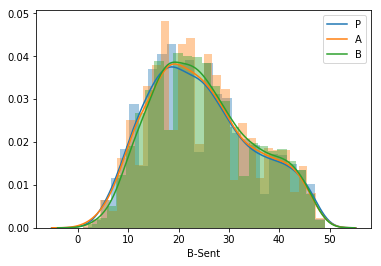

In [15]:
import seaborn as sns

sns.distplot(train_df['Pronoun-Sent'].map(lambda ele: len(ele.split(" "))), kde_kws={"label": "P"})

sns.distplot(train_df['A-Sent'].map(lambda ele: len(ele.split(" "))), kde_kws={"label": "A"})

sns.distplot(train_df['B-Sent'].map(lambda ele: len(ele.split(" "))), kde_kws={"label": "B"})

In [16]:
train_p_tokenized = sentences_to_sequences([row[0] for row in train_tokenized])
train_a_tokenized = sentences_to_sequences([row[1] for row in train_tokenized])
train_b_tokenized = sentences_to_sequences([row[2] for row in train_tokenized])

test_p_tokenized = sentences_to_sequences([row[0] for row in test_tokenized])
test_a_tokenized = sentences_to_sequences([row[1] for row in test_tokenized])
test_b_tokenized = sentences_to_sequences([row[2] for row in test_tokenized])

dev_p_tokenized = sentences_to_sequences([row[0] for row in dev_tokenized])
dev_a_tokenized = sentences_to_sequences([row[1] for row in dev_tokenized])
dev_b_tokenized = sentences_to_sequences([row[2] for row in dev_tokenized])

seq_p_train = sequence.pad_sequences(train_p_tokenized, maxlen = max_len, padding='post')
seq_a_train = sequence.pad_sequences(train_a_tokenized, maxlen = max_len, padding='post')
seq_b_train = sequence.pad_sequences(train_b_tokenized, maxlen = max_len, padding='post')

seq_p_test = sequence.pad_sequences(test_p_tokenized, maxlen = max_len, padding='post')
seq_a_test = sequence.pad_sequences(test_a_tokenized, maxlen = max_len, padding='post')
seq_b_test = sequence.pad_sequences(test_b_tokenized, maxlen = max_len, padding='post')

seq_p_dev = sequence.pad_sequences(dev_p_tokenized, maxlen = max_len, padding='post')
seq_a_dev = sequence.pad_sequences(dev_a_tokenized, maxlen = max_len, padding='post')
seq_b_dev = sequence.pad_sequences(dev_b_tokenized, maxlen = max_len, padding='post')

train_p_pos = poses_to_sequences([row[0] for row in train_tokenized])
train_a_pos = poses_to_sequences([row[1] for row in train_tokenized])
train_b_pos = poses_to_sequences([row[2] for row in train_tokenized])

test_p_pos = poses_to_sequences([row[0] for row in test_tokenized])
test_a_pos = poses_to_sequences([row[1] for row in test_tokenized])
test_b_pos = poses_to_sequences([row[2] for row in test_tokenized])

dev_p_pos = poses_to_sequences([row[0] for row in dev_tokenized])
dev_a_pos = poses_to_sequences([row[1] for row in dev_tokenized])
dev_b_pos = poses_to_sequences([row[2] for row in dev_tokenized])

pos_p_train = sequence.pad_sequences(train_p_pos, maxlen = max_len, padding='post')
pos_a_train = sequence.pad_sequences(train_a_pos, maxlen = max_len, padding='post')
pos_b_train = sequence.pad_sequences(train_b_pos, maxlen = max_len, padding='post')

pos_p_test = sequence.pad_sequences(test_p_pos, maxlen = max_len, padding='post')
pos_a_test = sequence.pad_sequences(test_a_pos, maxlen = max_len, padding='post')
pos_b_test = sequence.pad_sequences(test_b_pos, maxlen = max_len, padding='post')

pos_p_dev = sequence.pad_sequences(dev_p_pos, maxlen = max_len, padding='post')
pos_a_dev = sequence.pad_sequences(dev_a_pos, maxlen = max_len, padding='post')
pos_b_dev = sequence.pad_sequences(dev_b_pos, maxlen = max_len, padding='post')

index_p_train = train_df['Pronoun-Sent-Offset'].values
index_a_train = train_df['A-Sent-Offset'].values
index_b_train = train_df['B-Sent-Offset'].values

index_p_test = test_df['Pronoun-Sent-Offset'].values
index_a_test = test_df['A-Sent-Offset'].values
index_b_test = test_df['B-Sent-Offset'].values

index_p_dev = dev_df['Pronoun-Sent-Offset'].values
index_a_dev = dev_df['A-Sent-Offset'].values
index_b_dev = dev_df['B-Sent-Offset'].values

pa_pos_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_pos_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_pos_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'A-offset')

pb_pos_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_pos_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_pos_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'B-offset')

In [17]:
X_train = [seq_p_train, seq_a_train, seq_b_train, pos_p_train, pos_a_train, pos_b_train, index_p_train, index_a_train, index_b_train, pa_pos_tra, pb_pos_tra]
X_dev = [seq_p_dev, seq_a_dev, seq_b_dev, pos_p_dev, pos_a_dev, pos_b_dev, index_p_dev, index_a_dev, index_b_dev, pa_pos_dev, pb_pos_dev]
X_test = [seq_p_test, seq_a_test, seq_b_test, pos_p_test, pos_a_test, pos_b_test, index_p_test, index_a_test, index_b_test, pa_pos_test, pb_pos_test]

In [18]:
def _row_to_y(row):
    if row.loc['A-coref']:
        return 0
    if row.loc['B-coref']:
        return 1
    return 2

y_train = train_df.apply(_row_to_y, axis=1)
y_dev = dev_df.apply(_row_to_y, axis=1)
y_test = test_df.apply(_row_to_y, axis=1)

# Define Keras Layers

In [19]:
def _dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
class AttentionWeight(Layer):
    """
        This code is a modified version of cbaziotis implementation:  GithubGist cbaziotis/AttentionWithContext.py
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, steps)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWeight())
        """

    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWeight, self).__init__(**kwargs)

    def build(self, input_shape):
        shape1 = input_shape[0]
        shape2 = input_shape[1]

        self.W = self.add_weight((shape2[-1], shape1[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((shape2[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, inputs, mask=None):
        x = inputs[0]
        u = inputs[1]
        
        uit = _dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = K.batch_dot(uit, u)

        a = activations.softmax(ait, axis=-1)
        
        return a

    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError('A `Dot` layer should be called '
                             'on a list of 2 inputs.')
        shape1 = list(input_shape[0])
        shape2 = list(input_shape[1])
        
        return shape1[0], shape1[1]

    def get_config(self):
        config = {
            'W_regularizer': regularizers.serialize(self.W_regularizer),
            'b_regularizer': regularizers.serialize(self.b_regularizer),
            'W_constraint': constraints.serialize(self.W_constraint),
            'b_constraint': constraints.serialize(self.b_constraint),
            'bias': self.bias
        }
        base_config = super(AttentionWeight, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    
class FeatureSelection1D(Layer):
    """
        Normalize feature along a specific axis.
        Supports Masking.

        # Input shape
            A ND tensor with shape: `(samples, timesteps, features)
            A 2D tensor with shape: [samples, num_selected_features]
        # Output shape
            ND tensor with shape: `(samples, num_selected_features, features)`.
        :param kwargs:
        """

    def __init__(self, num_selects, **kwargs):

        self.num_selects = num_selects
        self.supports_masking = True
        super(FeatureSelection1D, self).__init__(**kwargs)

    def build(self, input_shape):

        super(FeatureSelection1D, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # don't pass the mask to the next layers
        return None

    def call(self, inputs, mask=None):
        if not isinstance(inputs, list) or len(inputs) != 2:
            raise ValueError('FeatureSelection1D layer should be called '
                             'on a list of 2 inputs.')

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a = K.cast(mask, K.floatx()) * inputs[0]
        else:
            a = inputs[0]

        b = inputs[1]

        a = tf.batch_gather(
            a, b
        )

        return a

    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError('A `FeatureSelection1D` layer should be called '
                             'on a list of 2 inputs.')
        shape1 = list(input_shape[0])
        shape2 = list(input_shape[1])

        if shape2[0] != shape1[0]:
            raise ValueError("batch size must be same")

        if shape2[1] != self.num_selects:
            raise ValueError("must conform to the num_select")

        return (shape1[0], self.num_selects, shape1[2])

    def get_config(self):
        config = {
            'num_selects': self.num_selects
        }
        base_config = super(FeatureSelection1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Build and Train Model

### RNN Attention

In [20]:
model_name = "rnnattetion_glove"

In [21]:
def build_e2e_birnn_attention_model(
        voca_dim, time_steps, pos_tag_size, pos_tag_dim, extra_feature_dims, output_dim, rnn_dim, model_dim, mlp_dim,
        item_embedding=None, rnn_depth=1, mlp_depth=1,
        embed_dropout=0.5, drop_out=0.5, rnn_drop_out=0., rnn_state_drop_out=0.,
        trainable_embedding=False, gpu=False, return_customized_layers=False):
    """
    Create A End-to-End Bidirectional RNN Attention Model.

    :param voca_dim: vocabulary dimension size.
    :param time_steps: the length of input
    :param extra_feature_dims: the dimention size of the auxilary feature
    :param output_dim: the output dimension size
    :param model_dim: rrn dimension size
    :param mlp_dim: the dimension size of fully connected layer
    :param item_embedding: integer, numpy 2D array, or None (default=None)
        If item_embedding is a integer, connect a randomly initialized embedding matrix to the input tensor.
        If item_embedding is a matrix, this matrix will be used as the embedding matrix.
        If item_embedding is None, then connect input tensor to RNN layer directly.
    :param rnn_depth: rnn depth
    :param mlp_depth: the depth of fully connected layers
    :param drop_out: dropout rate of fully connected layers
    :param rnn_drop_out: dropout rate of rnn layers
    :param rnn_state_drop_out: dropout rate of rnn state tensor
    :param trainable_embedding: boolean
    :param gpu: boolean, default=False
        If True, CuDNNLSTM is used instead of LSTM for RNN layer.
    :param return_customized_layers: boolean, default=False
        If True, return model and customized object dictionary, otherwise return model only
    :return: keras model
    """
    
    # sequences inputs
    if item_embedding is not None:
        inputp = models.Input(shape=(time_steps,), dtype='int32', name='inputp')
        inputa = models.Input(shape=(time_steps,), dtype='int32', name='inputa')
        inputb = models.Input(shape=(time_steps,), dtype='int32', name='inputb')
        inputs = [inputp, inputa, inputb]
        
        if isinstance(item_embedding, np.ndarray):
            assert voca_dim == item_embedding.shape[0]
            embed_dim = item_embedding.shape[1]
            emb_layer = layers.Embedding(
                voca_dim, item_embedding.shape[1], input_length=time_steps,
                weights=[item_embedding, ], trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )
        elif utils.is_integer(item_embedding):
            embed_dim = item_embedding
            emb_layer = layers.Embedding(
                voca_dim, item_embedding, input_length=time_steps,
                trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )
        else:
            raise ValueError("item_embedding must be either integer or numpy matrix")

        xs = list(map(
            lambda input_: emb_layer(input_),
            inputs
        ))
    else:
        inputp = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='inputp')
        inputa = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='inputa')
        inputb = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='inputb')
        embed_dim = voca_dim
        xs = [inputp, inputa, inputb]
        
    # pos tag
    inputposp = models.Input(shape=(time_steps,), dtype='int32', name='inputposp')
    inputposa = models.Input(shape=(time_steps,), dtype='int32', name='inputposa')
    inputposb = models.Input(shape=(time_steps,), dtype='int32', name='inputposb')
    inputpos = [inputposp, inputposa, inputposb]
    pos_emb_layer = layers.Embedding(
        pos_tag_size, pos_tag_dim, input_length=time_steps,
        trainable=True, mask_zero=False, name='pos_embedding_layer0'
    )
    xpos = list(map(
        lambda input_: pos_emb_layer(input_),
        inputpos
    ))
    
#     embed_concate_layer = layers.Concatenate(axis=2, name="token_embed_concate_layer")
#     for i in range(len(xs)):
#         xs[i] = embed_concate_layer([xs[i], xpos[i]])
    
    # mention position in the sentence
    inputpi = models.Input(shape=(1,), dtype='int32', name='inputpi')
    inputai = models.Input(shape=(1,), dtype='int32', name='inputai')
    inputbi = models.Input(shape=(1,), dtype='int32', name='inputbi')
    xis = [inputpi, inputai, inputbi]
    
    # addtional mention-pair features
    inputpa = models.Input(shape=(extra_feature_dims,), dtype='float32', name='inputpa')
    inputpb = models.Input(shape=(extra_feature_dims,), dtype='float32', name='inputpb')
    xextrs = [inputpa, inputpb]
    
    # rnn
    birnns = list()
    rnn_batchnorms = list()
    rnn_dropouts = list()
    if gpu:
        # rnn encoding
        for i in range(rnn_depth):
            rnn_dropout = layers.SpatialDropout1D(rnn_drop_out)
            birnn = layers.Bidirectional(
                layers.CuDNNGRU(rnn_dim, return_sequences=True),
                name='bi_lstm_layer' + str(i))
            
            birnns.append(birnn)
            rnn_dropouts.append(rnn_dropout)
        
        xs_ = list()
        for x_ in xs:
            for i in range(len(birnns)):
                x_ = rnn_dropouts[i](x_)
                x_ = birnns[i](x_)
            xs_.append(x_)
        xs = xs_
    else:
        # rnn encoding
        for i in range(rnn_depth):
            birnn = layers.Bidirectional(
                layers.GRU(rnn_dim, return_sequences=True, dropout=rnn_drop_out,
                            recurrent_dropout=rnn_state_drop_out),
                name='bi_lstm_layer' + str(i))
            birnns.append(birnn)
            
        xs_ = list()
        for x_ in xs:
            for i in range(len(birnns)):
                x_ = birnns[i](x_)
            xs_.append(x_)
        xs = xs_
    
    # attention aggregated rnn embedding + mention rnn embedding + mention-pair features
    select_layer = FeatureSelection1D(1, name='boundary_selection_layer')
    flatten_layer1 = layers.Flatten('channels_first', name="flatten_layer1")
    permute_layer = layers.Permute((2, 1), name='permuted_attention_x')
    attent_weight = AttentionWeight(name="attention_weight")
    focus_layer = layers.Dot([2, 1], name='focus' + '_layer')
    reshape_layer = layers.Reshape((1, rnn_dim*2), name="reshape_layer")
    concate_layer = layers.Concatenate(axis=1, name="attention_concate_layer")
    flatten_layer = layers.Flatten('channels_first', name="flatten_layer")
    for i in range(len(xs)):
            
        select_ = select_layer([xs[i], xis[i]])
        flatten_select_ = flatten_layer1(select_)
        att = attent_weight([xs[i], flatten_select_])
        
        focus = focus_layer([permute_layer(xs[i]), att])
        xs[i] = concate_layer([select_, reshape_layer(focus)])
        xs[i] = flatten_layer(xs[i])
    
    feature_concate_layer =  layers.Concatenate(axis=1, name="feature_feature_layer")
    xpa = feature_concate_layer([xs[0], xs[1], xextrs[0]])
    xpb = feature_concate_layer([xs[0], xs[2], xextrs[1]])
    
    # MLP Layers
    dropout_layer = layers.Dropout(rate=embed_dropout, name="dropout_layer")
    map_layer = layers.Dense(model_dim, activation='relu', kernel_initializer='lecun_normal', name='relu_layer')
    xpa = dropout_layer(xpa)
    xpa = map_layer(xpa)
    xpb = dropout_layer(xpb)
    xpb = map_layer(xpb)
    
    x = layers.Concatenate(axis=1, name="embed_concate_layer")([xpa, xpb])
    x = layers.Dropout(rate=drop_out, name="embed_dropout_layer")(x)

    # MLP Layers
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model([inputp, inputa, inputb] + inputpos + xis + [inputpa, inputpb], outputs)

    if return_customized_layers:
        return model, {'FeatureSelection1D': FeatureSelection1D, 'AttentionWeight': AttentionWeight}

    return model

### Build Model

In [22]:
voca_dim = embedding_matrix.shape[0]
pos_tag_size = len(pos_index)
time_steps = max_len

embed_dim = embedding_matrix.shape[1]
pos_tag_dim = 5
extra_feature_dims = num_pos_features
output_dim = 3
rnn_dim = 50
model_dim = 10
mlp_dim = 10
rnn_depth = 1
mlp_depth=1
embed_dropout = 0.5
drop_out=0.2
rnn_drop_out=0.5
gpu = True
return_customized_layers=False
n_fold = 5
epochs = 1000

Fold 0 started at Thu Apr 11 08:58:47 2019
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


single model train loss: 
0.5235728913545609
single model validation loss: 
0.6517555086160278
single model dev loss: 
0.6116747326172726


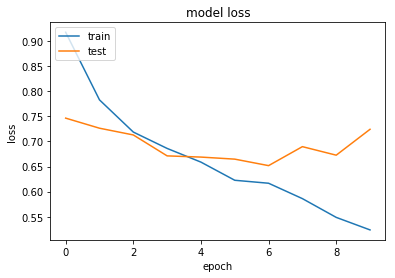

Fold 1 started at Thu Apr 11 08:59:25 2019


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


single model train loss: 
0.520852864086628
single model validation loss: 
0.6297593620251892
single model dev loss: 
0.6531307600489822


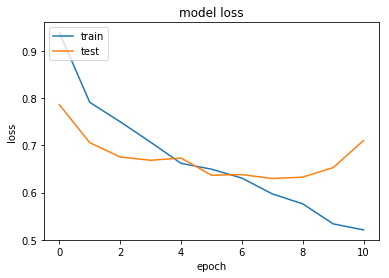

Fold 2 started at Thu Apr 11 09:00:04 2019


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


single model train loss: 
0.5365733262896538
single model validation loss: 
0.66664632986659
single model dev loss: 
0.6842023296848978


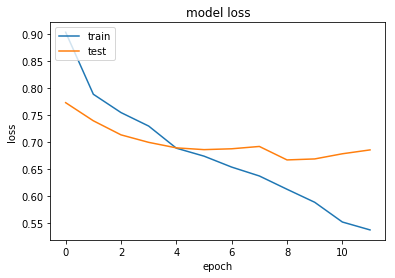

Fold 3 started at Thu Apr 11 09:00:45 2019


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


single model train loss: 
0.4853038673102856
single model validation loss: 
0.6225374103739415
single model dev loss: 
0.6214240510070816


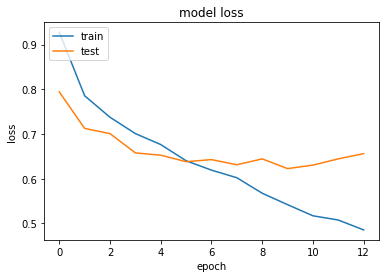

Fold 4 started at Thu Apr 11 09:01:30 2019


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


single model train loss: 
0.5080548723042011
single model validation loss: 
0.6170938073121164
single model dev loss: 
0.6729787895749949


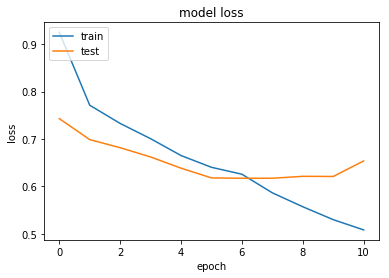

cv model accuracy: 
0.60572438641607


In [23]:
# Training and cross-validation
dummy_X = np.zeros(shape=(train_df.shape[0], 1))

folds = KFold(n_splits=n_fold, shuffle=False, random_state=3)
is_first_fold = True
preds_train = list()
preds_dev = None
preds_test = None
for fold_n, (train_index, val_index) in enumerate(folds.split(dummy_X)):
    # split training and validation data
    print('Fold', fold_n, 'started at', time.ctime())
    
    Xt = [XX[train_index] for XX in X_train]
    Xv = [XX[val_index] for XX in X_train]
    
    yt = y_train.values[train_index]
    yv = y_train.values[val_index]
    
    model = build_e2e_birnn_attention_model(
        voca_dim, time_steps, pos_tag_size, pos_tag_dim, extra_feature_dims, output_dim, rnn_dim, model_dim, mlp_dim,
        item_embedding=embedding_matrix, rnn_depth=rnn_depth, mlp_depth=mlp_depth,
        embed_dropout=embed_dropout, drop_out=drop_out, rnn_drop_out=rnn_drop_out, rnn_state_drop_out=rnn_drop_out,
        trainable_embedding=False, gpu=gpu, return_customized_layers=return_customized_layers)
    
    adam = ko.Nadam(clipnorm=1.0)
    model.compile(adam, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

    early_stop = kc.EarlyStopping(monitor = "val_loss", mode = "min", patience=3, restore_best_weights=True)
    history = model.fit(Xt, yt, epochs=epochs, validation_data=(Xv, yv), callbacks = [early_stop], verbose=0, batch_size=32)
    
    preds_train_tmp = model.predict(Xv)
    preds_dev_tmp = model.predict(X_dev)
    preds_test_tmp = model.predict(X_test)
    
    print("single model train loss: ")
    print(history.history['loss'][-1])
    print("single model validation loss: ")
    print(measure_log_loss(yv, preds_train_tmp))
    print("single model dev loss: ")
    print(measure_log_loss(y_dev.values, preds_dev_tmp))
    
    
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(model_name + '_lossplot.png')
    #plt.close(fig)
    
    if is_first_fold:
        preds_train.append(preds_train_tmp)
        preds_dev = preds_dev_tmp
        preds_test = preds_test_tmp
    else:
        preds_train.append(preds_train_tmp)
        preds_dev += preds_dev_tmp
        preds_test += preds_test_tmp
        
    is_first_fold = False

preds_train = np.concatenate(preds_train)
preds_dev /= n_fold
preds_test /= n_fold
print("cv model accuracy: ")
print(measure_log_loss(y_dev.values, preds_dev))

add_results(train_df, preds_train)
add_results(dev_df, preds_dev)
add_results(test_df, preds_test)
train_file_name = model_name + "_train.csv"
dev_file_name = model_name + "_dev.csv"
test_file_name = model_name + "_test.csv"

train_df.to_csv(train_file_name, index=False)
dev_df.to_csv(dev_file_name, index=False)
test_df.to_csv(test_file_name, index=False)

drop_results(train_df)
drop_results(dev_df)
drop_results(test_df)